In [1]:
%matplotlib inline
import multiprocessing

from brian2 import *
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

import bluepyopt as bpop
from bluepyopt.parameters import Parameter

In [2]:
area = 20000*umetre**2

def run_brian_sim(parameters, input_current, dt=0.01*ms, runtime=20*ms):
    # Parameters
    Cm = 1*ufarad*cm**-2 * area
    El = -65*mV
    EK = -90*mV
    ENa = 50*mV
    VT = -63*mV
    defaultclock.dt = dt
    I = TimedArray(input_current, dt=dt)
    # The model
    eqs = Equations('''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
    dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
        (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
        (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    g_na : siemens (constant)
    g_kd : siemens (constant)
    gl   : siemens (constant)
    ''')

    G = NeuronGroup(1, eqs, method='exponential_euler')
    G.v = El
    G.set_states(parameters, units=False)
    mon = StateMonitor(G, 'v', record=0)
    run(runtime)
    return mon.v[0]/mV

"correct" parameters: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06}


Text(0, 0.5, 'v (mV)')

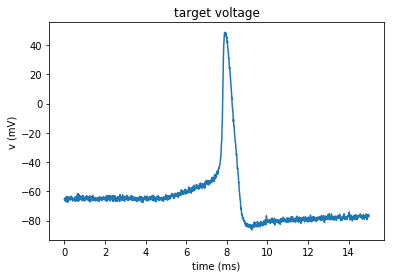

In [3]:
# Generate a step-current input and an "experimental" voltage trace
dt = 0.01*ms
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
params = {'gl': float(5e-5*siemens*cm**-2 * area),
          'g_na': float(100*msiemens*cm**-2 * area),
          'g_kd': float(30*msiemens*cm**-2 * area)}
print ('"correct" parameters:', params)

voltage = run_brian_sim(params, input_current, dt=dt, runtime=15*ms)  # returns voltage in mV
voltage += np.random.randn(len(voltage))
plot(np.arange(len(voltage))*dt/ms, voltage); title('target voltage'); xlabel('time (ms)'); ylabel('v (mV)')

In [4]:
class HHBrianEvaluator(bpop.evaluators.Evaluator):
    def __init__(self, input_current, dt, runtime, target_voltage):
        self.input_current = input_current
        self.dt = dt
        self.runtime = runtime
        self.target_voltage = target_voltage
        super(HHBrianEvaluator, self).__init__(objectives=['RMS'],
                                               params=[Parameter('gl', bounds=[1e-09, 1e-07]),
                                                       Parameter('g_na', bounds=[1e-07, 1e-03]),
                                                       Parameter('g_kd', bounds=[1e-08, 1e-04])])
    
    def evaluate_with_dicts(self, param_dict):
        voltage = run_brian_sim(param_dict, self.input_current, self.dt, self.runtime)
        return {'RMS': np.array([np.sqrt(np.mean((voltage - self.target_voltage)**2))])}
    
    def evaluate_with_lists(self, param_list):
        gl, g_na, g_kd = param_list
        param_dict = {'gl': gl, 'g_na': g_na, 'g_kd': g_kd}
        return [self.evaluate_with_dicts(param_dict)['RMS']]


In [5]:
pool = multiprocessing.Pool()  # Use available cores
evaluator = HHBrianEvaluator(input_current, dt=0.01*ms, runtime=15*ms, target_voltage=voltage)
opt = bpop.deapext.optimisations.DEAPOptimisation(evaluator, map_function=pool.map)
%time final_pop, hall_of_fame, logs, hist = opt.run(max_ngen=20)

CPU times: user 165 ms, sys: 4.22 ms, total: 169 ms
Wall time: 16.4 s


In [6]:
best_ind = hall_of_fame[0]
print ('Best individual: ', best_ind)
print ('Fitness values: ', best_ind.fitness.values)

Best individual:  [7.649143062743348e-08, 7.267280134595518e-05, 1.338652331817965e-05]
Fitness values:  (array([5.05042337]),)


In [7]:
# Run the simulation for the best parameters
fitted_voltage = run_brian_sim({'gl': best_ind[0],
                                'g_na': best_ind[1],
                                'g_kd': best_ind[2]},
                               input_current, dt=0.01*ms, runtime=15*ms)

10. nS 76.49143063 nS
20. uS 72.67280135 uS
6. uS 13.38652332 uS


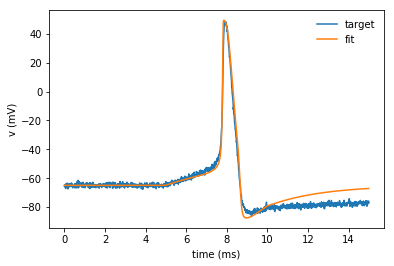

In [9]:
plot(np.arange(len(voltage))*dt/ms, voltage, label='target')
plot(np.arange(len(voltage))*dt/ms, fitted_voltage, label='fit')
legend(frameon=False); xlabel('time (ms)'); ylabel('v (mV)')
print (params['gl']*siemens, best_ind[0]*siemens)
print (params['g_na']*siemens, best_ind[1]*siemens)
print (params['g_kd']*siemens, best_ind[2]*siemens)


Text(0, 0.5, 'fitness value')

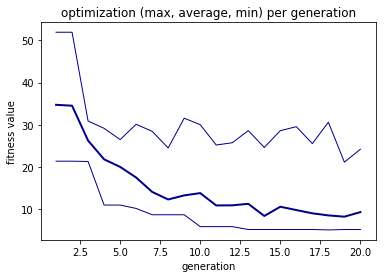

In [10]:
# Plot statistics about the optimization process
plot(logs.select('gen'), logs.select('max'), lw=1, color='darkblue')
plot(logs.select('gen'), logs.select('avg'), lw=2, color='darkblue')
plot(logs.select('gen'), logs.select('min'), lw=1, color='darkblue')
title('optimization (max, average, min) per generation'); xlabel('generation'); ylabel('fitness value')